### Segmentação de Clientes utilizando Machine Learning

#### Descrição do Problema

Uma loja de varejo online sediada no Reino Unido, visa compreender melhor as características de compra dos seus clientes. As transações ocorreram entre 01/12/2009 e 09/12/2011. A empresa vende principalmente artigos de presente exclusivos para todas as ocasiões. Muitos clientes da empresa são atacadistas.

#### Objetivo do Projeto

O objetivo é segmentar os clientes em grupos com comportamentos de compras semelhantes. Com isso a empresa pode construir melhores conexões a fim de fidelizar seus clientes e recuperar clientes perdidos.

#### Solução

Vou utilizar o modelo RFM (Recência, Frequência e Valor Monetário) que é uma técnica eficaz para segmentar clientes com base em seu comportamento de compra.

**1. Recência (R)** Refere-se ao tempo desde a última compra do cliente. Clientes que compraram recentemente têm maior probabilidade de comprar novamente.<br>
**2. Frequência (F)** Avalia quantas vezes um cliente comprou em um determinado período. Clientes frequentes são valiosos, pois tendem a ter maior lealdade.<br>
**3. Valor Monetário (M)** Refere-se ao total gasto por cada cliente em um determinado período. Clientes que gastam mais são geralmente mais valiosos para o negócio.

Obs: Por convenção o nome das variáveis será em língua inglesa.


### Importando as bibliotecas

In [ ]:
# Manipulação dos dados
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Clusterização
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#
from utils.help_functions import plot_silhouette_analysis

# Configurações
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.max_columns', None)

# Remove as mensagens de warning
import warnings
warnings.filterwarnings('ignore')

# Cores
PALETA = sns.color_palette()
PALETA3 = sns.color_palette("Paired")
BLUE = PALETA[0]
ORANGE = PALETA[1]
GREEN = PALETA[2]
YELLOW = PALETA3[6]
LIGHT_PURPLE = PALETA3[8]
PURPLE = PALETA3[9]

### Análise Exploratória

In [2]:
df = pd.read_excel("../data/raw/online_retail_II.xlsx", sheet_name=0)
df.shape

(525461, 8)

#### Dicionário dos dados

|Variável           |Descrição               |
|---------------|-------------------|
|Invoice        |Número da fatura. Número integral de 6 dígitos atribuído exclusivamente a cada transação. Se este código começar com a letra "c", indica um cancelamento.|
|StockCode      |Código do produto (item). Número integral de 5 dígitos atribuído exclusivamente a cada produto distinto.|
|Description    |Nome do produto (item).|
|Quantity       |As quantidades de cada produto (item) por transação.|
|InvoiceDate    |O dia e a hora em que uma transação foi gerada.|
|UnitPrice      |Preço unitário. Preço do produto por unidade em libras esterlinas|
|CustomerID     |Número do cliente. Número integral de 5 dígitos atribuído exclusivamente a cada cliente.|

In [3]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom


Observação:

- No dicionário dos dados a descrição da variável ``StockCode`` diz que são números de 5 dígitos, porém, como podemos observar acima temos algumas letras no final do código. Quando eu estiver analisando as variáveis categóricas será um ponto de investigação.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


- O tipo de dados inferido para a variável Customer ID está float64, porém, está é uma variável de identificação, categórica.

In [5]:
df['Customer ID'] = df['Customer ID'].astype('object')

Verificando dados ausentes

In [6]:
df.isnull().sum() /len(df) * 100

Invoice                       0.00
StockCode                     0.00
Description                   0.56
Quantity                      0.00
InvoiceDate                   0.00
Price                         0.00
Customer ID                  20.54
Country                       0.00
dtype: float64

- Podemos observar que as variáveis Description e Customer ID apresentam valores ausentes.
- Como o projeto é sobre clusterização de clientes, a falta de informação sobre quem é o cliente inviabiliza colocá-lo em um cluster. A decisão será de remoção dessas observações.


In [7]:
df_cleaned = df.copy()
df_cleaned = df_cleaned.dropna(subset=["Customer ID"])

In [8]:
len(df_cleaned)/len(df)


0.7946051181724239

In [9]:
df_cleaned.isnull().sum() /len(df) * 100

Invoice                       0.00
StockCode                     0.00
Description                   0.00
Quantity                      0.00
InvoiceDate                   0.00
Price                         0.00
Customer ID                   0.00
Country                       0.00
dtype: float64

- Foram removidos 21% dos dados.

Verificando dados duplicados

In [10]:
df_cleaned.duplicated().sum()

np.int64(6771)

In [11]:
df_cleaned[df_cleaned.duplicated()]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
371,489517,21912,VINTAGE SNAKES & LADDERS,1,2009-12-01 11:34:00,3.75,16329.00,United Kingdom
383,489517,22130,PARTY CONE CHRISTMAS DECORATION,6,2009-12-01 11:34:00,0.85,16329.00,United Kingdom
384,489517,22319,HAIRCLIPS FORTIES FABRIC ASSORTED,12,2009-12-01 11:34:00,0.65,16329.00,United Kingdom
385,489517,21913,VINTAGE SEASIDE JIGSAW PUZZLES,1,2009-12-01 11:34:00,3.75,16329.00,United Kingdom
386,489517,21821,GLITTER STAR GARLAND WITH BELLS,1,2009-12-01 11:34:00,3.75,16329.00,United Kingdom
...,...,...,...,...,...,...,...,...
523258,538035,20728,LUNCH BAG CARS BLUE,3,2010-12-09 13:03:00,1.65,16065.00,United Kingdom
523356,538051,22659,LUNCH BOX I LOVE LONDON,2,2010-12-09 13:24:00,1.95,18041.00,United Kingdom
525170,538155,21907,I'M ON HOLIDAY METAL SIGN,1,2010-12-09 16:52:00,2.10,16907.00,United Kingdom
525293,538166,21915,RED HARMONICA IN BOX,5,2010-12-09 18:09:00,1.25,17965.00,United Kingdom


- Não são dados duplicados. São compras do mesmo cliente, na mesma fatura, porém, muda o produto e a quantidade.

#### Variáveis Categóricas

In [12]:
df_cleaned.describe(include=['O'])

,Invoice,StockCode,Description,Customer ID,Country
count,417534,417534,417534,417534.00,417534
unique,23587,4031,4459,4383.00,37
top,500356,85123A,WHITE HANGING HEART T-LIGHT HOLDER,14911.00,United Kingdom
freq,270,3245,3245,5710.00,379423


Observações:

- Temos 4383 clientes registrados.
- São 23.587 faturas.
- São 4031 produtos.
- São 37 paises.

##### **Invoice**

A variável Invoice contém faturas canceladas (indicadas com a letra 'c' no início da fatura).

In [13]:
df_cleaned[df_cleaned['Invoice'].str.startswith('C') == True]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.00,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.00,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.00,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.00,Australia
...,...,...,...,...,...,...,...,...
524695,C538123,22956,36 FOIL HEART CAKE CASES,-2,2010-12-09 15:41:00,2.10,12605.00,Germany
524696,C538124,M,Manual,-4,2010-12-09 15:43:00,0.50,15329.00,United Kingdom
524697,C538124,22699,ROSES REGENCY TEACUP AND SAUCER,-1,2010-12-09 15:43:00,2.95,15329.00,United Kingdom
524698,C538124,22423,REGENCY CAKESTAND 3 TIER,-1,2010-12-09 15:43:00,12.75,15329.00,United Kingdom


In [14]:
# Porcentagem
round(9839 / len(df_cleaned) * 100, 2)

2.36

- Interessante que nas faturas canceladas a valores negativos na variável Quantity.
- São 9839 faturas canceladas, que representa 2.36% da base de dados.
- Não vou manter na análise as faturas que foram canceladas.

In [15]:
df_cleaned['Invoice'] = df_cleaned['Invoice'].astype('str')
df_cleaned = df_cleaned[~df_cleaned['Invoice'].str.startswith('C')]
df_cleaned

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


##### **StockCode**

Preciso verificar as letras após os digitos. Encontrei também um valor ``M`` na variável.

In [16]:
# Pesquisando os valores que não contenham apenas os 5 dígitos.
df_cleaned[df_cleaned["StockCode"].str.match("^\\d{5}$") == False]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
12,489436,48173C,DOOR MAT BLACK FLOCK,10,2009-12-01 09:06:00,5.95,13078.00,United Kingdom
23,489436,35004B,SET OF 3 BLACK FLYING DUCKS,12,2009-12-01 09:06:00,4.65,13078.00,United Kingdom
28,489436,84596F,SMALL MARSHMALLOWS PINK BOWL,8,2009-12-01 09:06:00,1.25,13078.00,United Kingdom
...,...,...,...,...,...,...,...,...
525387,538170,84029E,RED WOOLLY HOTTIE WHITE HEART.,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525388,538170,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,2,2010-12-09 19:32:00,3.75,13969.00,United Kingdom
525389,538170,85232B,SET OF 3 BABUSHKA STACKING TINS,2,2010-12-09 19:32:00,4.95,13969.00,United Kingdom
525435,538171,47591D,PINK FAIRY CAKE CHILDRENS APRON,1,2010-12-09 20:01:00,1.95,17530.00,United Kingdom


In [17]:
df_cleaned[df_cleaned["StockCode"].str.match("^\\d{5}$") == False]['StockCode'].nunique()

1293

- Há 56.766 registros de StockCode que não contém apenas 5 dígitos.

In [18]:
# Pesquindo por todos os valores que não contem os 5 dígitos.
df_cleaned[df_cleaned["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False]['StockCode'].unique()

array(['POST', 'C2', 'M', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS',
       'ADJUST', 'D', 'ADJUST2', 'SP1002'], dtype=object)

In [19]:
# Não contém os 5 dígitos e não contém os 5 dígitos com letras no final.
df_cleaned[(df_cleaned["StockCode"].str.match("^\\d{5}$") == False) & (df_cleaned["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == False)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
89,489439,POST,POSTAGE,3,2009-12-01 09:28:00,18.00,12682.00,France
126,489444,POST,POSTAGE,1,2009-12-01 09:55:00,141.00,12636.00,USA
173,489447,POST,POSTAGE,1,2009-12-01 10:10:00,130.00,12362.00,Belgium
625,489526,POST,POSTAGE,6,2009-12-01 11:50:00,18.00,12533.00,Germany
1244,489557,POST,POSTAGE,4,2009-12-01 12:52:00,18.00,12490.00,France
...,...,...,...,...,...,...,...,...
522954,538002,C2,CARRIAGE,1,2010-12-09 11:48:00,50.00,14932.00,Channel Islands
522974,538003,POST,POSTAGE,8,2010-12-09 12:05:00,18.00,12429.00,Denmark
523064,538008,POST,POSTAGE,5,2010-12-09 12:17:00,18.00,12683.00,France
524491,538093,POST,POSTAGE,5,2010-12-09 14:49:00,18.00,12682.00,France


In [20]:
df_cleaned[df_cleaned['Invoice'] == '489439']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
71,489439,22065,CHRISTMAS PUDDING TRINKET POT,12,2009-12-01 09:28:00,1.45,12682.00,France
72,489439,22138,BAKING SET 9 PIECE RETROSPOT,9,2009-12-01 09:28:00,4.95,12682.00,France
73,489439,22139,RETRO SPOT TEA SET CERAMIC 11 PC,9,2009-12-01 09:28:00,4.95,12682.00,France
74,489439,22352,LUNCHBOX WITH CUTLERY RETROSPOT,12,2009-12-01 09:28:00,2.55,12682.00,France
75,489439,85014A,BLACK/BLUE DOTS RUFFLED UMBRELLA,3,2009-12-01 09:28:00,5.95,12682.00,France
76,489439,85014B,RED/WHITE DOTS RUFFLED UMBRELLA,3,2009-12-01 09:28:00,5.95,12682.00,France
77,489439,16161P,WRAP ENGLISH ROSE,25,2009-12-01 09:28:00,0.42,12682.00,France
78,489439,16169N,WRAP BLUE RUSSIAN FOLKART,25,2009-12-01 09:28:00,0.42,12682.00,France
79,489439,21491,SET OF THREE VINTAGE GIFT WRAPS,6,2009-12-01 09:28:00,1.95,12682.00,France
80,489439,22333,RETRO SPORT PARTY BAG + STICKER SET,8,2009-12-01 09:28:00,1.65,12682.00,France


- Por falta de informação mais detalhada sobre os tipos de StockCode, vou trabalhar apenas com os StockCode que contenham os 5 dígitos.
- Realizando testes utilizando apenas os StockCode com 5 dígitos a clusterização não ficou muito boa. Testei com os 5 dígitos + os 5 dígitos com as letras no final e ficou melhor.

In [21]:
df_cleaned["StockCode"] = df_cleaned["StockCode"].astype("str")

mask = ((df_cleaned["StockCode"].str.match("^\\d{5}$") == True)
    |   (df_cleaned["StockCode"].str.match("^\\d{5}[a-zA-Z]+$") == True))

df_cleaned = df_cleaned[mask]
df_cleaned

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


##### Country

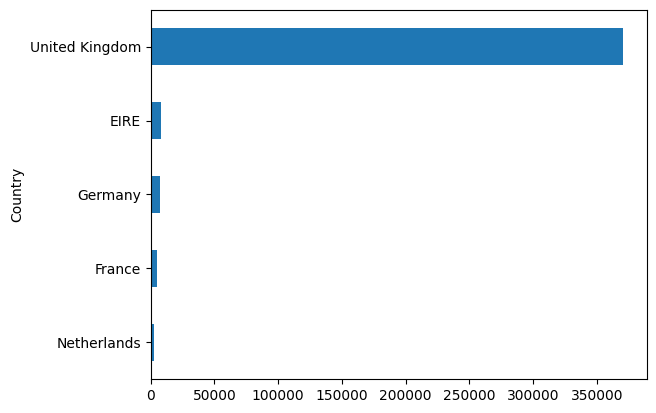

In [22]:
# Top 5 nacionalidades dos clientes
df_cleaned['Country'].value_counts()[:5].sort_values(ascending=True).plot(kind='barh');

#### Variáveis Numéricas

In [23]:
df_cleaned.describe(exclude=['object', 'datetime'])

,Quantity,Price
count,406323.00,406323.00
mean,13.62,2.99
std,97.00,4.29
min,1.00,0.00
25%,2.00,1.25
50%,5.00,1.95
75%,12.00,3.75
max,19152.00,295.00


In [24]:
df_cleaned[df_cleaned['Price'] == 0].head(10)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.00,16126.00,United Kingdom
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.00,15658.00,United Kingdom
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.00,14108.00,United Kingdom
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.00,14108.00,United Kingdom
32916,492079,85042,ANTIQUE LILY FAIRY LIGHTS,8,2009-12-15 13:49:00,0.00,15070.00,United Kingdom
40101,492760,21143,ANTIQUE GLASS HEART DECORATION,12,2009-12-18 14:22:00,0.00,18071.00,United Kingdom
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.00,14258.00,United Kingdom
48342,493899,22355,"CHARLOTTE BAG , SUKI DESIGN",10,2010-01-08 10:43:00,0.00,12417.00,Belgium
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.00,16858.00,United Kingdom
111348,500073,21662,VINTAGE GLASS COFFEE CADDY,1,2010-03-04 11:44:00,0.00,13047.00,United Kingdom


In [25]:
len(df_cleaned[df_cleaned['Price'] == 0])

28

- Estranho. Temos 28 transações com preço do produto igual a 0. Pode ser alguma promoção que foi feita, algo do tipo.
- Porém, pela falta de informação vou remover essas 28 observações.

In [26]:
df_cleaned = df_cleaned[df_cleaned['Price'] > 0]

### Feature Engineering

#### RFM Features

A análise RFM (Recência, Frequência e Valor Monetário) é uma técnica eficaz para segmentar clientes com base em seu comportamento de compra. Aqui está um resumo de como aplicar essa metodologia:

**Recência (R)**: Refere-se ao tempo decorrido desde a data da última compra do cliente. Isso sugere que os clientes que compraram mais recentemente estão usando nossos produtos, nos contataram recentemente e provavelmente escolherão nossa empresa novamente. Portanto, uma Recência menor, ou seja, mais próxima da data da última compra, resultará em pontuações mais altas.

**Frequência (F)**: É a quantidade de compras realizadas pelo cliente, que pode ser simplesmente pensada como a quantidade de faturas. Quanto mais o cliente escolhe a nossa empresa, mais podemos esperar que ele continue com esse comportamento no futuro.

**Monetário (M)**: Refere-se a quanto dinheiro o cliente pagou por suas compras. Semelhante à Frequência, o valor pago tem um efeito positivo em estar nos segmentos superiores do grupo.

A segmentação RFM ajuda a personalizar as estratégias de marketing, permitindo um melhor direcionamento das ações e aumentando a eficácia nas campanhas.

In [27]:
df_cleaned['TotalValue'] = df_cleaned['Quantity'] * df_cleaned['Price']
df_cleaned

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalValue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom,5.90
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,3.75
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom,7.50


In [28]:
# Agrupando os valores por cliente.
# (Valor total gasto, Quantas vezes comprou, Data da última compra)
df_rfm = df_cleaned.groupby(by="Customer ID").agg(Monetary=("TotalValue", "sum"),
                                                  Frequency=("Invoice", "nunique"),
                                                  LastInvoice=("InvoiceDate", "max")).reset_index()

df_rfm.head()

,Customer ID,Monetary,Frequency,LastInvoice
0,12346.00,169.36,2,2010-06-28 13:53:00
1,12347.00,1323.32,2,2010-12-07 14:57:00
2,12348.00,221.16,1,2010-09-27 14:59:00
3,12349.00,2221.14,2,2010-10-28 08:23:00
4,12351.00,300.93,1,2010-11-29 15:23:00


In [29]:
max_invoice_date = df_rfm["LastInvoice"].max()
df_rfm["Recency"] = (max_invoice_date - df_rfm["LastInvoice"]).dt.days

df_rfm.head()

,Customer ID,Monetary,Frequency,LastInvoice,Recency
0,12346.00,169.36,2,2010-06-28 13:53:00,164
1,12347.00,1323.32,2,2010-12-07 14:57:00,2
2,12348.00,221.16,1,2010-09-27 14:59:00,73
3,12349.00,2221.14,2,2010-10-28 08:23:00,42
4,12351.00,300.93,1,2010-11-29 15:23:00,10


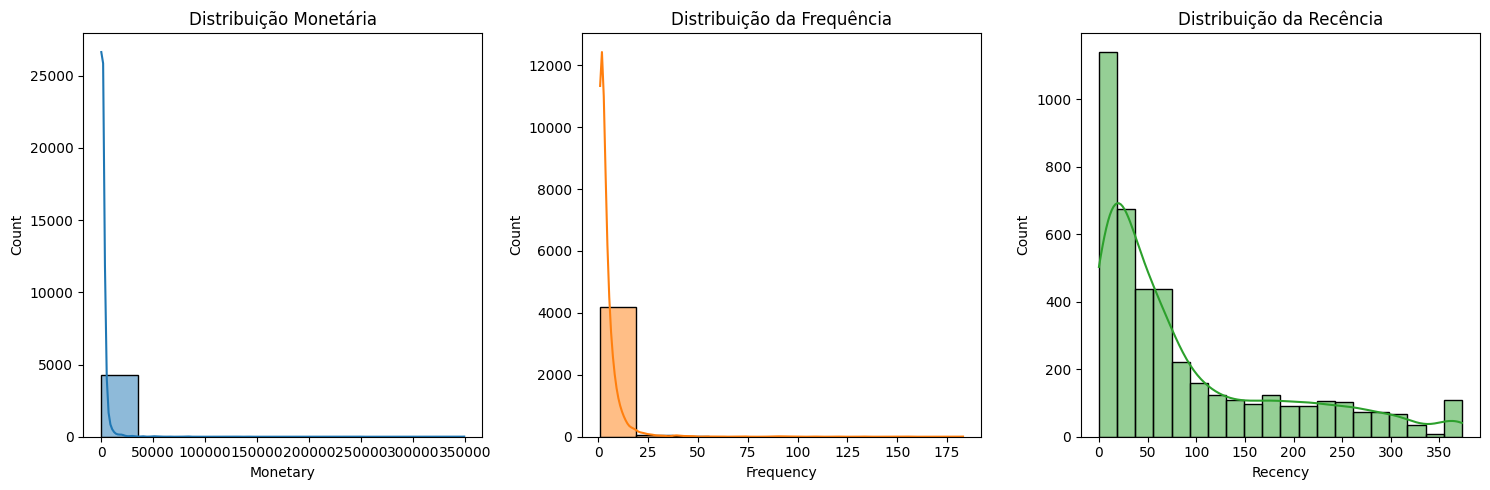

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(df_rfm['Monetary'], kde=True, bins=10, ax = axs[0], color=BLUE)
axs[0].set_title('Distribuição Monetária')

sns.histplot(df_rfm['Frequency'], kde=True, bins=10, ax = axs[1], color=ORANGE)
axs[1].set_title('Distribuição da Frequência')

sns.histplot(df_rfm['Recency'], kde=True, bins=20, ax = axs[2], color=GREEN)
axs[2].set_title('Distribuição da Recência')

plt.tight_layout()
plt.show()

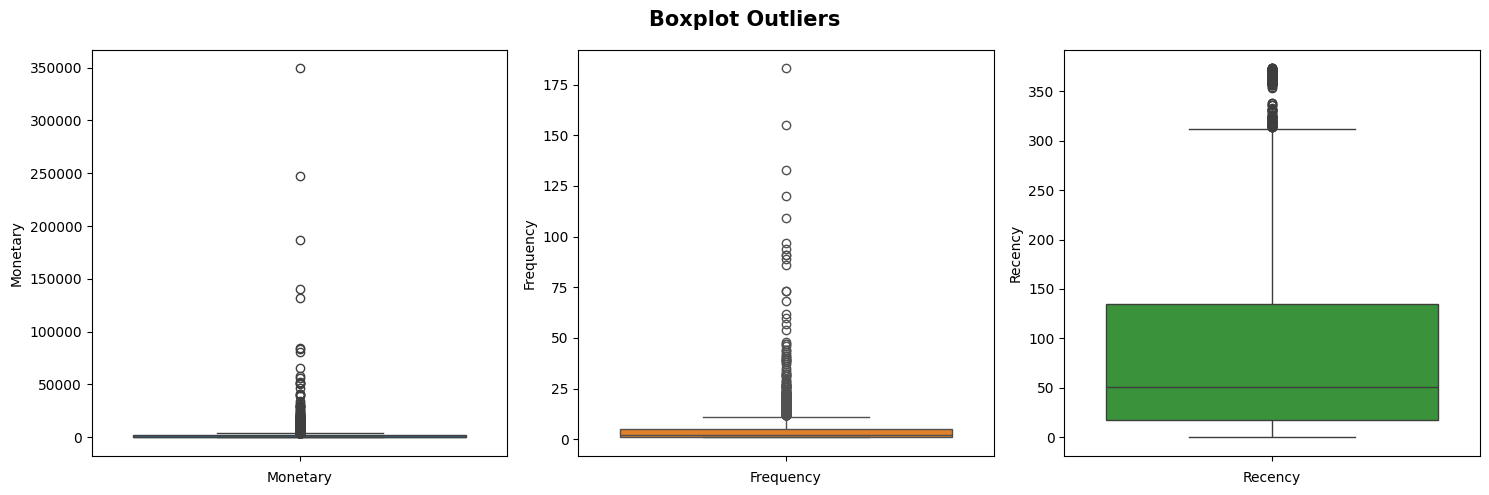

In [32]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=df_rfm['Monetary'], color=BLUE, ax=axs[0])
axs[0].set_xlabel('Monetary')
sns.boxplot(data=df_rfm['Frequency'], color=ORANGE, ax=axs[1])
axs[1].set_xlabel('Frequency')
sns.boxplot(data=df_rfm['Recency'], color=GREEN, ax=axs[2])
axs[2].set_xlabel('Recency')
plt.suptitle('Boxplot Outliers', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

- Clientes com um valor monetário muito acima da média e clientes com uma frequência de compra muita alta serão analisados posteriormente.
- Vou utilizarr a técnica de IQR (Intervalo Interquartil) para separar os outliers.

In [33]:
M_Q1 = df_rfm["Monetary"].quantile(0.25)
M_Q3 = df_rfm["Monetary"].quantile(0.75)
M_IQR = M_Q3 - M_Q1

df_monetary_outliers = df_rfm[(df_rfm["Monetary"] > (M_Q3 + 1.5 * M_IQR)) | (df_rfm["Monetary"] < (M_Q1 - 1.5 * M_IQR))].copy()
df_monetary_outliers.describe()

,Customer ID,Monetary,Frequency,LastInvoice,Recency
count,423.00,423.00,423.00,423,423.00
mean,15103.04,12188.10,17.17,2010-11-09 12:26:02.978723328,30.04
min,12357.00,3802.04,1.00,2009-12-10 18:03:00,0.00
25%,13622.00,4605.94,8.00,2010-11-08 13:17:30,3.00
50%,14961.00,6191.32,12.00,2010-11-26 12:19:00,13.00
75%,16692.00,10273.24,18.00,2010-12-06 10:34:30,31.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,364.00
std,1728.66,25830.85,19.73,NaN,51.54


In [34]:
F_Q1 = df_rfm['Frequency'].quantile(0.25)
F_Q3 = df_rfm['Frequency'].quantile(0.75)
F_IQR = F_Q3 - F_Q1

df_frequency_outliers = df_rfm[(df_rfm['Frequency'] > (F_Q3 + 1.5 * F_IQR)) | (df_rfm['Frequency'] < (F_Q1 - 1.5 * F_IQR))].copy()
df_frequency_outliers.describe()

,Customer ID,Monetary,Frequency,LastInvoice,Recency
count,279.00,279.00,279.00,279,279.00
mean,15352.66,14409.71,23.81,2010-11-23 11:06:20.645161216,16.09
min,12437.00,1094.39,12.00,2010-05-12 16:51:00,0.00
25%,13800.00,4331.56,13.00,2010-11-20 13:14:30,2.00
50%,15465.00,6615.77,17.00,2010-12-02 10:46:00,7.00
75%,16828.50,11692.41,23.00,2010-12-07 11:08:30,19.00
max,18260.00,349164.35,183.00,2010-12-09 19:32:00,211.00
std,1748.43,31381.74,21.93,NaN,26.59


In [35]:
df_no_outliers = df_rfm[(~df_rfm.index.isin(df_monetary_outliers.index)) & (~df_rfm.index.isin(df_frequency_outliers.index))]
df_no_outliers.describe()

,Customer ID,Monetary,Frequency,LastInvoice,Recency
count,3809.00,3809.00,3809.00,3809,3809.00
mean,15376.48,885.50,2.86,2010-09-03 11:16:46.516146176,97.08
min,12346.00,1.55,1.00,2009-12-01 10:49:00,0.00
25%,13912.00,279.91,1.00,2010-07-08 14:48:00,22.00
50%,15389.00,588.05,2.00,2010-10-12 16:25:00,58.00
75%,16854.00,1269.05,4.00,2010-11-17 13:14:00,154.00
max,18287.00,3788.21,11.00,2010-12-09 20:01:00,373.00
std,1693.20,817.67,2.24,NaN,98.11


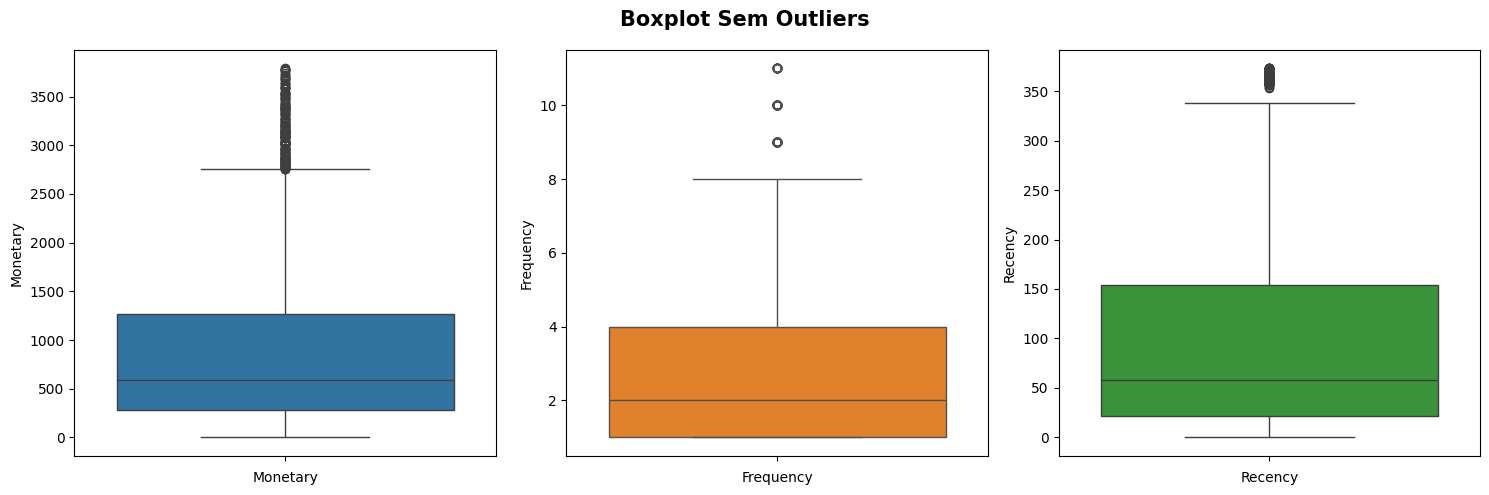

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(data=df_no_outliers['Monetary'], color=BLUE, ax=axs[0])
axs[0].set_xlabel('Monetary')
sns.boxplot(data=df_no_outliers['Frequency'], color=ORANGE, ax=axs[1])
axs[1].set_xlabel('Frequency')
sns.boxplot(data=df_no_outliers['Recency'], color=GREEN, ax=axs[2])
axs[2].set_xlabel('Recency')
plt.suptitle('Boxplot Sem Outliers', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

#### Padronização das Variáveis - Standard Scale

Transforma os dados para ter média 0 e desvio padrão 1. A formula é 

$$
z = \frac{x - \mu}{\sigma}
$$

onde $\mu$ é a média da característica e $\sigma$ é o desvio padrão.

In [37]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_no_outliers[["Monetary", "Frequency", "Recency"]])
df_scaled = pd.DataFrame(scaled_data, index=df_no_outliers.index, columns=("Monetary", "Frequency", "Recency"))
df_scaled

,Monetary,Frequency,Recency
0,-0.88,-0.38,0.68
1,0.54,-0.38,-0.97
2,-0.81,-0.83,-0.25
3,1.63,-0.38,-0.56
4,-0.72,-0.83,-0.89
...,...,...,...
4280,-0.30,1.40,-0.82
4281,-0.58,-0.83,-0.32
4282,-0.62,-0.83,2.02
4283,0.44,-0.38,0.14


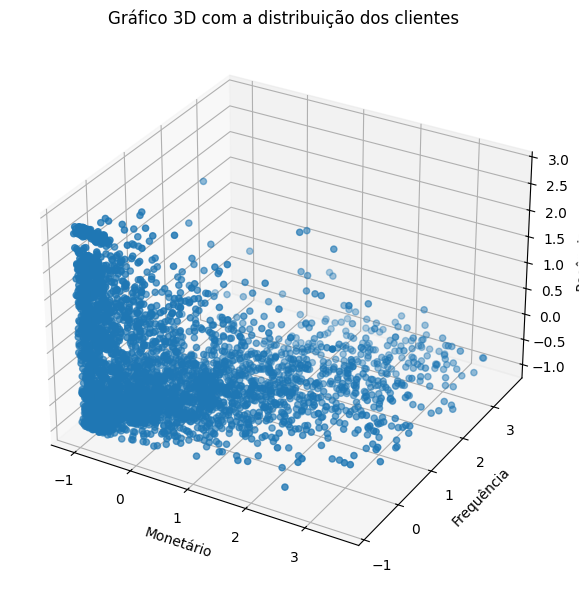

In [38]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(df_scaled["Monetary"], df_scaled["Frequency"], df_scaled["Recency"])
ax.set_xlabel('Monetário')
ax.set_ylabel('Frequência')
ax.set_zlabel('Recência')

ax.set_title('Gráfico 3D com a distribuição dos clientes')

plt.tight_layout()
plt.show()

### Modelagem - KMeans Clustering

O **K-means** é um algoritmo de aprendizado não supervisionado amplamente utilizada para agrupamento (clustering) de dados, visando dividir o conjunto de dados em K grupos (clusters), onde cada ponto de dado pertence ao grupo cujo centroide (o ponto médio do cluster) é mais próximo.

A **inércia** (inertia) é uma métrica utilizada no algoritmo K-means para avaliar a qualidade dos clusters formados. Ela mede a soma das distâncias quadráticas entre cada ponto de dado e o centroide do cluster ao qual pertence. Utiliza-se o método do cotovelo (Elbow Method) para avaliar a inércia. Uma inércia menor indica que os pontos de dados estão mais próximos de seus respectivos centroides, sugerindo que o agrupamento é mais compacto e, portanto, de melhor qualidade.

O **Silhouette Score** é uma métrica utilizada para avaliar a qualidade de um agrupamento (clustering). Ele mede o quão bem cada ponto de dado se encaixa em seu próprio cluster em comparação com outros clusters. Essa métrica varia de -1 a +1, onde:

- +1: O ponto está bem agrupado com outros pontos do mesmo cluster e longe de outros clusters.
- 0: O ponto está perto da borda entre dois clusters, o que indica que pode estar mal classificado.
- -1: O ponto pode estar mal alocado, pois está mais próximo de um cluster diferente.

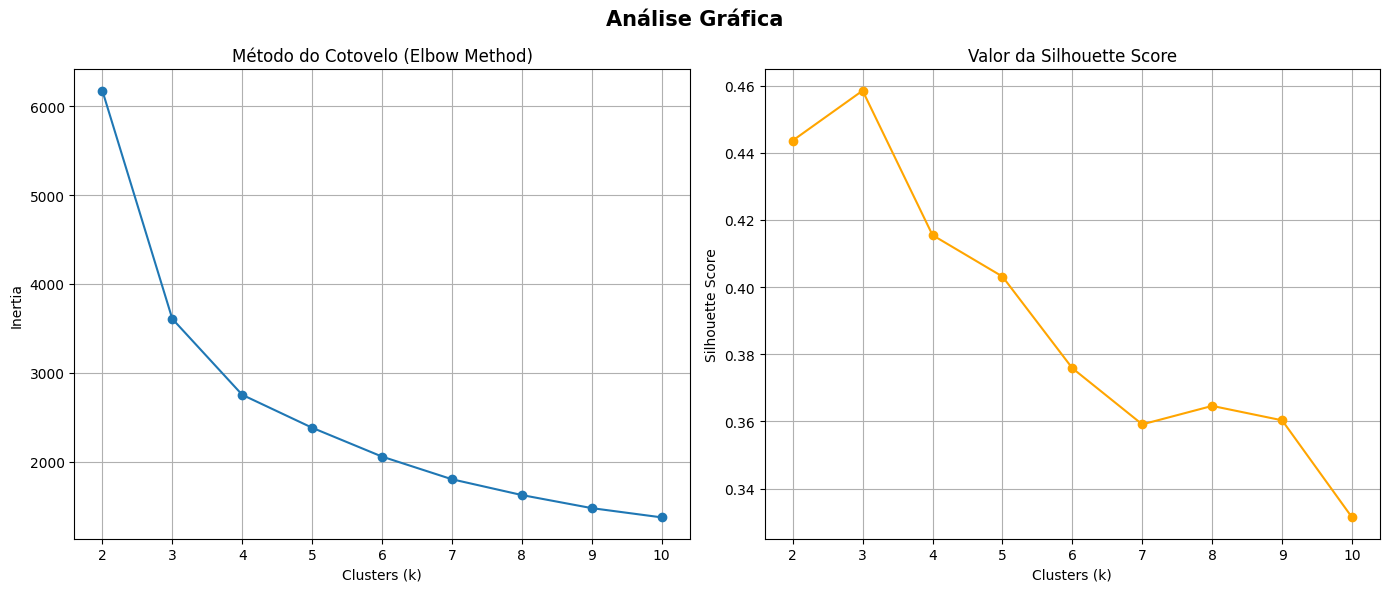

In [39]:
np.random.seed(0)
max_k = 10

inertia = []
silhoutte_scores = []
k_values = range(2, max_k + 1)

for k in k_values:

    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=1000, n_init=10, random_state=43)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil_score = silhouette_score(df_scaled, labels)
    silhoutte_scores.append(sil_score)
    inertia.append(kmeans.inertia_)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertia, marker='o')
plt.title('Método do Cotovelo (Elbow Method)')
plt.xlabel('Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_values, silhoutte_scores, marker='o', color='orange')
plt.title('Valor da Silhouette Score')
plt.xlabel('Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.grid(True)

plt.suptitle('Análise Gráfica', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

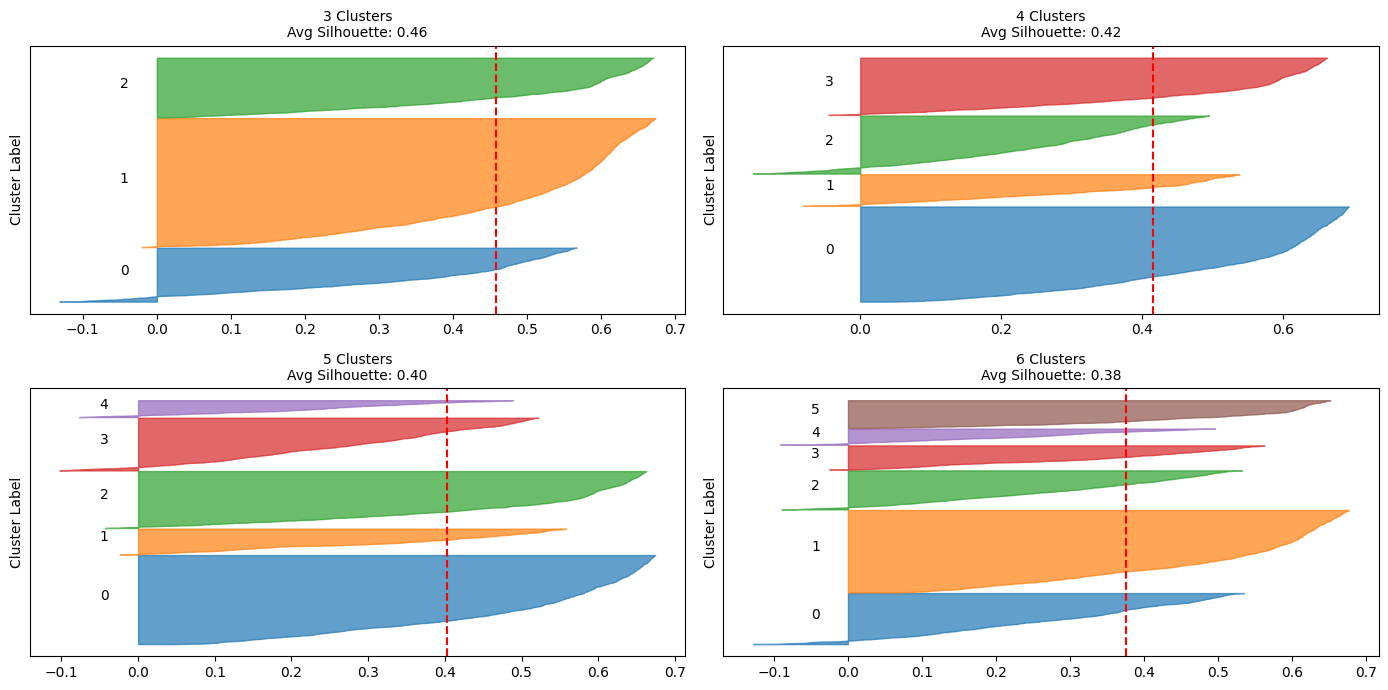

In [ ]:
# Analisando os diagramas de Silhouette para diversos valores de clusters.
cluster_list = [3, 4, 5, 6]
plot_silhouette_analysis(df_scaled, n_clusters=cluster_list, n_cols=2)

In [43]:
np.random.seed(0)

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=1000, n_init=10, random_state=43)
cluster_labels = kmeans.fit_predict(df_scaled)
cluster_labels

array([3, 2, 0, ..., 3, 2, 2], dtype=int32)

In [44]:
df_no_outliers["Cluster"] = cluster_labels
df_no_outliers

,Customer ID,Monetary,Frequency,LastInvoice,Recency,Cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,3
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,2
2,12348.00,221.16,1,2010-09-27 14:59:00,73,0
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,2
4,12351.00,300.93,1,2010-11-29 15:23:00,10,0
...,...,...,...,...,...,...
4280,18283.00,641.77,6,2010-11-22 15:30:00,17,2
4281,18284.00,411.68,1,2010-10-04 11:33:00,66,0
4282,18285.00,377.00,1,2010-02-17 10:24:00,295,3
4283,18286.00,1246.43,2,2010-08-20 11:57:00,111,2


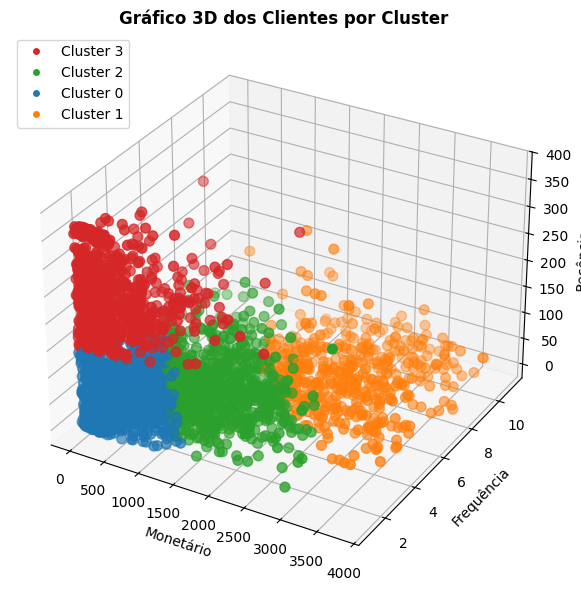

In [45]:
cluster_colors = {0: PALETA[0],  
                  1: PALETA[1],  
                  2: PALETA[2],  
                  3: PALETA[3]}

colors = df_no_outliers['Cluster'].map(cluster_colors)

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(df_no_outliers['Monetary'], 
                     df_no_outliers['Frequency'], 
                     df_no_outliers['Recency'], 
                     c=colors, marker='o', s=50)

ax.set_xlabel('Monetário')
ax.set_ylabel('Frequência')
ax.set_zlabel('Recência')
ax.set_title('Gráfico 3D dos Clientes por Cluster', fontweight='bold')

# Adicionando uma legenda
unique_clusters = df_no_outliers['Cluster'].unique()
handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {i}', 
                       markerfacecolor=cluster_colors[i]) for i in unique_clusters]
ax.legend(handles=handles, loc='upper left')

plt.tight_layout()
plt.show()

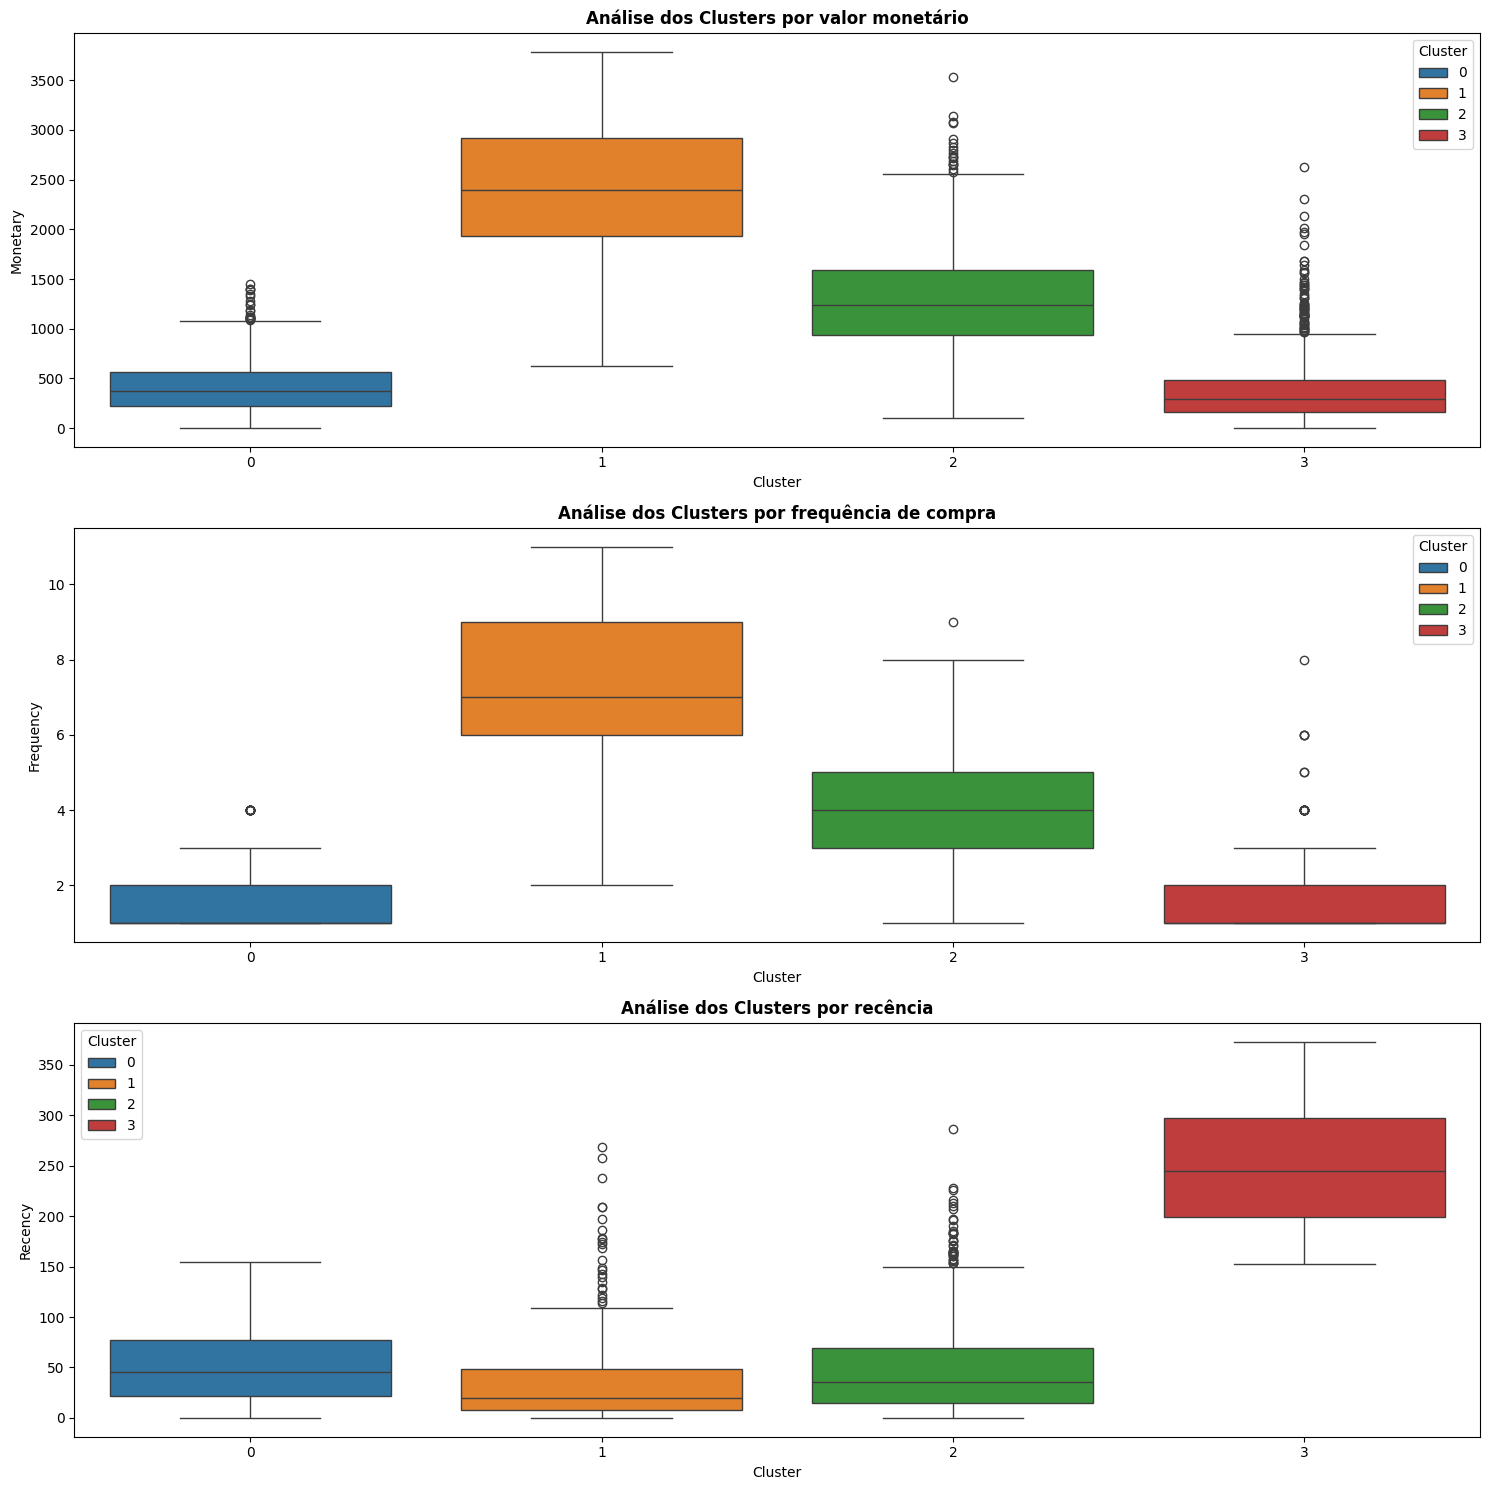

In [46]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

sns.boxplot(data=df_no_outliers, x='Cluster', y='Monetary', palette=cluster_colors, hue='Cluster', ax=ax[0])
ax[0].set_title('Análise dos Clusters por valor monetário', fontweight='bold')
sns.boxplot(data=df_no_outliers, x='Cluster', y='Frequency', palette=cluster_colors, hue='Cluster', ax=ax[1])
ax[1].set_title('Análise dos Clusters por frequência de compra', fontweight='bold')
sns.boxplot(data=df_no_outliers, x='Cluster', y='Recency', palette=cluster_colors, hue='Cluster', ax=ax[2])
ax[2].set_title('Análise dos Clusters por recência', fontweight='bold')

plt.tight_layout()
plt.show()

#### Análise dos Clientes

| Segmento      | Interpretação         | Ação      |
|---------------|-----------------------|-----------|
|Cluster 0     |Alerta: Baixo valor monetário, baixa frequência, compras não tão recentes.|Precisa de atenção, possivel perda. Descontos especiais|
|Cluster 1     |Cliente Bom: Bom valor monetário, alta frequência, comprando ativamente.| Programas de fidelidade, ofertas exclusivas.|
|Cluster 2     |Cliente Mediano: Valor monetário mediano, frequência mediana, compras não tão recentes.|Engajamento com promoções, precisamos mantê-los ativos.|
|Cluster 3     |Cliente Perdido: Baixo valor monetário, baixa frequência, compras a muito tempo atrás.|Campanhas de reativação.|

#### Análise dos Clientes Outliers

- Clientes com um valor monetário muito acima da média.
- Clientes com uma frequência de compra muito acima da média.

In [47]:
# Clientes que estão nos outliers de valor monetário e frequência
overlap_indices = df_monetary_outliers.index.intersection(df_frequency_outliers.index)

# Clientes com alto valor monetário 
monetary_only_outliers = df_monetary_outliers.drop(overlap_indices)

# Clientes com alta frequência nas compras
frequency_only_outliers = df_frequency_outliers.drop(overlap_indices)

# Clientes que estão nos outliers de valor monetário e frequência
monetary_and_frequency_outliers = df_monetary_outliers.loc[overlap_indices]

# Atribuindo um clusters a esses clientes manualmente
monetary_only_outliers["Cluster"] = -1
frequency_only_outliers["Cluster"] = -2
monetary_and_frequency_outliers["Cluster"] = -3

outlier_clusters_df = pd.concat([monetary_only_outliers, frequency_only_outliers, monetary_and_frequency_outliers])
outlier_clusters_df

,Customer ID,Monetary,Frequency,LastInvoice,Recency,Cluster
9,12357.00,11229.99,1,2010-11-16 10:05:00,23,-1
25,12380.00,4782.84,4,2010-08-31 14:54:00,100,-1
42,12409.00,12346.62,4,2010-10-15 10:24:00,55,-1
48,12415.00,19468.84,4,2010-11-29 15:07:00,10,-1
61,12431.00,4145.52,11,2010-12-01 10:03:00,8,-1
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3


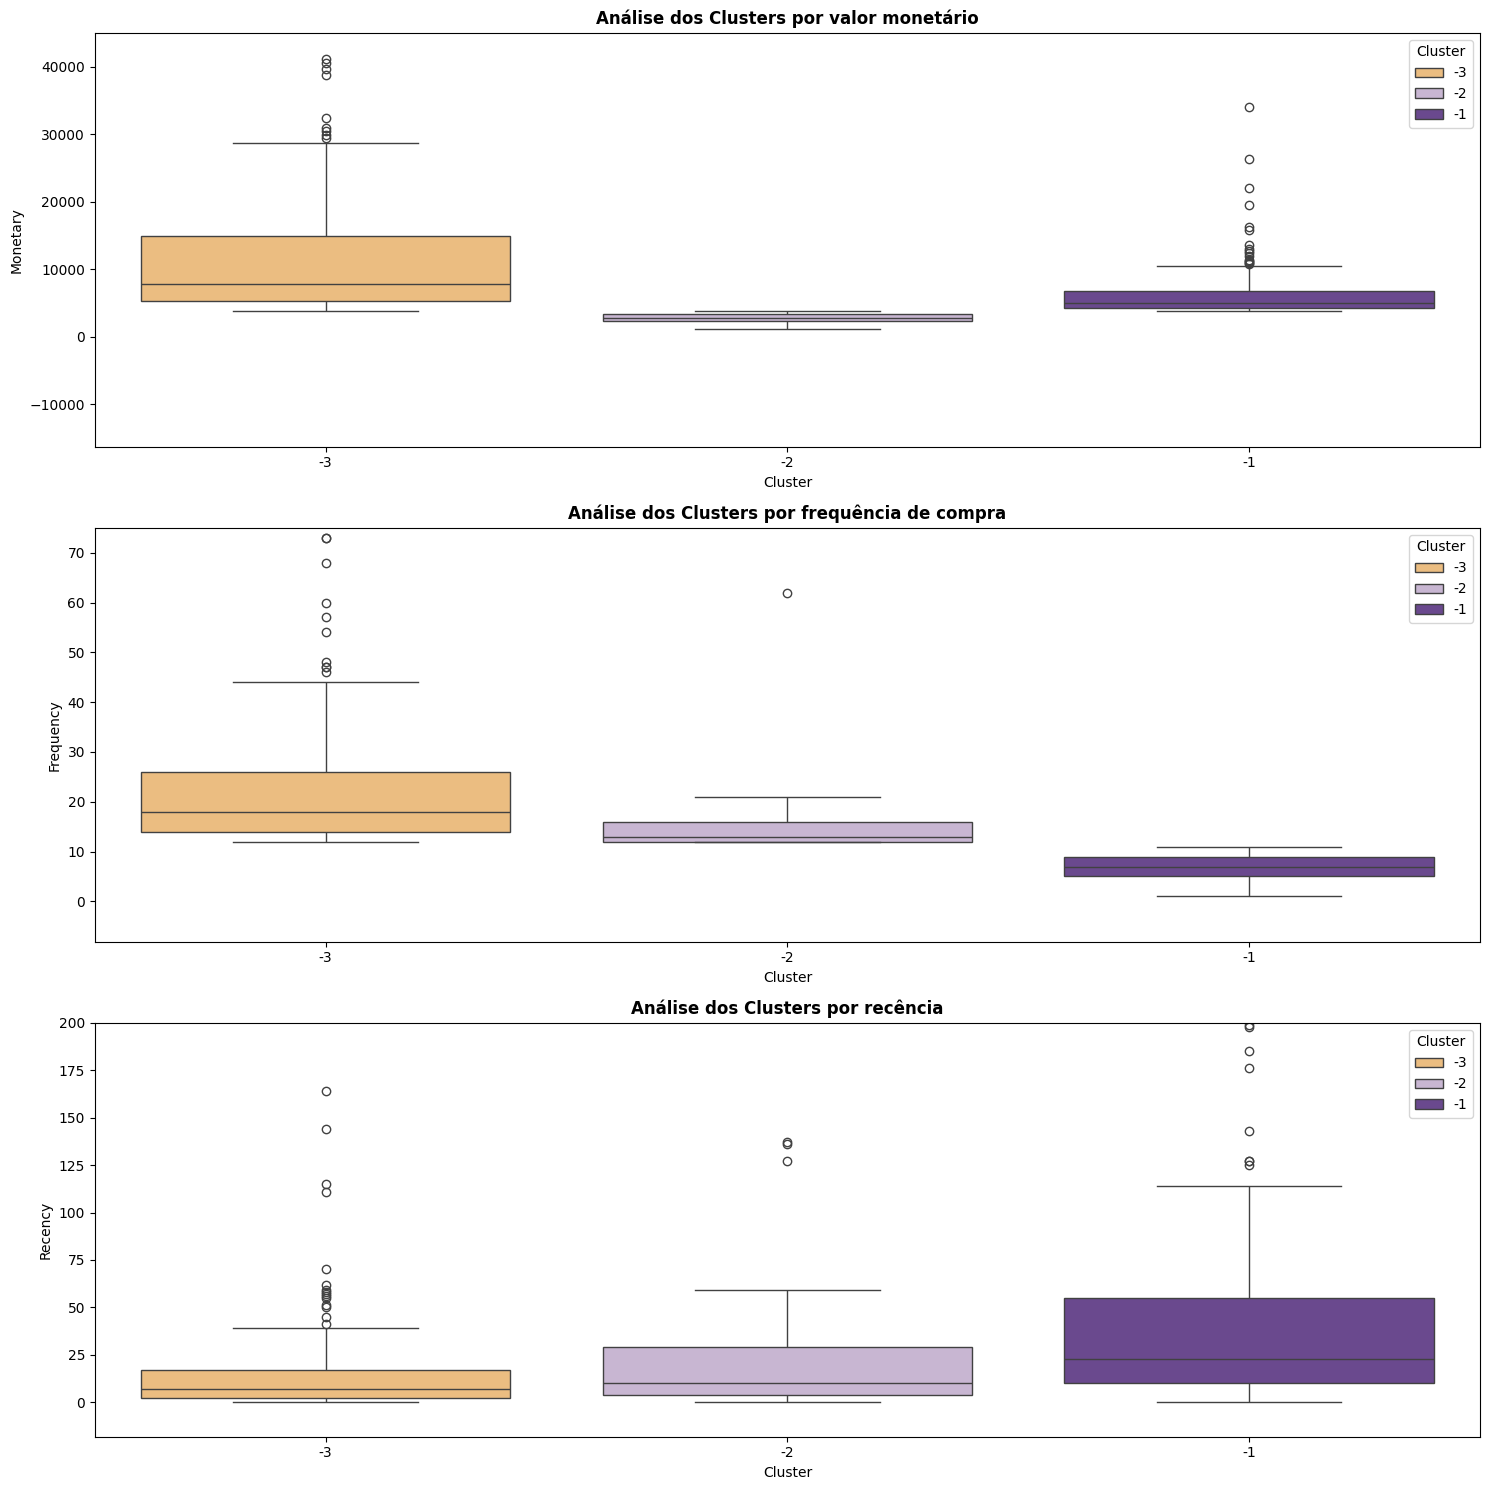

In [49]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

cluster_colors = {-1: PURPLE,
                  -2: LIGHT_PURPLE,
                  -3: YELLOW}

sns.boxplot(data=outlier_clusters_df, x='Cluster', y='Monetary', palette=cluster_colors, hue='Cluster', ax=ax[0])
ax[0].set_title('Análise dos Clusters por valor monetário', fontweight='bold')
ax[0].set_ylim(top=45000)
sns.boxplot(data=outlier_clusters_df, x='Cluster', y='Frequency', palette=cluster_colors, hue='Cluster', ax=ax[1])
ax[1].set_title('Análise dos Clusters por frequência de compra', fontweight='bold')
ax[1].set_ylim(top=75)
sns.boxplot(data=outlier_clusters_df, x='Cluster', y='Recency', palette=cluster_colors, hue='Cluster', ax=ax[2])
ax[2].set_title('Análise dos Clusters por recência', fontweight='bold')
ax[2].set_ylim(top=200)

plt.tight_layout()
plt.show()


| Segmento      | Interpretação         | Ação      |
|---------------|-----------------------|-----------|
|Cluster -1     |Novos Clientes:  Valor monetário extremamente alto com compras pouco frequentes.|Ofertas personalizadas para manter sua fidelidade.|
|Cluster -2     |Clientes Frequentes: Compradores frequentes que gastam menos por compra.|Pacote de ofertas para incentivar maiores gastos por visita.|
|Cluster -3     |Clientes Premium: Valor monetário extremamente alto e compras frequentes.|Atenção especial, cliente VIP.|

In [50]:
cluster_labels = {
    0: "ALERTA",
    1: "BONS",
    2: "MEDIANOS",
    3: "PERDIDOS",
    -1: "ÓTIMOS",
    -2: "FREQUENTES",
    -3: "PREMIUM"
}

## Conclusão

In [51]:
df_full_clustering = pd.concat([df_no_outliers, outlier_clusters_df])
df_full_clustering

,Customer ID,Monetary,Frequency,LastInvoice,Recency,Cluster
0,12346.00,169.36,2,2010-06-28 13:53:00,164,3
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,2
2,12348.00,221.16,1,2010-09-27 14:59:00,73,0
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,2
4,12351.00,300.93,1,2010-11-29 15:23:00,10,0
...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3


In [52]:
df_full_clustering["ClusterLabel"] = df_full_clustering["Cluster"].map(cluster_labels)
df_full_clustering

,Customer ID,Monetary,Frequency,LastInvoice,Recency,Cluster,ClusterLabel
0,12346.00,169.36,2,2010-06-28 13:53:00,164,3,PERDIDOS
1,12347.00,1323.32,2,2010-12-07 14:57:00,2,2,MEDIANOS
2,12348.00,221.16,1,2010-09-27 14:59:00,73,0,ALERTA
3,12349.00,2221.14,2,2010-10-28 08:23:00,42,2,MEDIANOS
4,12351.00,300.93,1,2010-11-29 15:23:00,10,0,ALERTA
...,...,...,...,...,...,...,...
4235,18223.00,7516.31,12,2010-11-17 12:20:00,22,-3,PREMIUM
4236,18225.00,7545.14,15,2010-12-09 15:46:00,0,-3,PREMIUM
4237,18226.00,6650.83,15,2010-11-26 15:51:00,13,-3,PREMIUM
4241,18231.00,4791.80,23,2010-10-29 14:17:00,41,-3,PREMIUM


In [53]:
# Dataframe com as características de média para RFM por cluster.
df_mean_rfm_cluster = df_full_clustering.groupby('ClusterLabel')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()
df_mean_rfm_cluster

,ClusterLabel,Recency,Frequency,Monetary
0,ALERTA,54.16,1.64,417.05
1,BONS,34.02,7.24,2427.11
2,FREQUENTES,23.08,15.04,2734.69
3,MEDIANOS,49.69,3.89,1306.86
4,PERDIDOS,251.28,1.43,384.78
5,PREMIUM,14.45,25.87,17147.66
6,ÓTIMOS,47.91,7.19,6498.45


In [51]:
df_mean_rfm_cluster.to_excel('../data/output/mean_rfm_cluster.xlsx', index=False)

In [52]:
# Salvando em um arquivo xlsx (excel)
df_full_clustering_xlsx = df_full_clustering[['Customer ID', 'Recency', 'Frequency', 'Monetary', 'ClusterLabel', 'Cluster']]
df_full_clustering_xlsx.to_excel('../data/output/clientes_clustering.xlsx', index=False)

In [54]:
# Montando um Dataframe com os clusters, a interpretação e possiveis açoes
df_clusters_interp = pd.DataFrame({
    'Segmento': ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster -1', 'Cluster -2', 'Cluster -3'],
    'Interpretação': ['Alerta: Baixo valor monetário, baixa frequência, compras não tão recentes.',
                      'Cliente Bom: Bom valor monetário, alta frequência, comprando ativamente.',
                      'Cliente Mediano: Valor monetário mediano, frequência mediana, compras não tão recentes.',
                      'Cliente Perdido: Baixo valor monetário, baixa frequência, compras a muito tempo atrás.',
                      'Ótimos Clientes:  Valor monetário extremamente alto com compras pouco frequentes.',
                      'Clientes Frequentes: Compradores frequentes que gastam menos por compra.',
                      'Clientes Premium: Valor monetário extremamente alto e compras frequentes.'],
    'Ação': ['Precisa de atenção, possível perda. Descontos especiais.',
             'Programas de fidelidade, ofertas exclusivas.',
             'Engajamento com promoções, precisamos mantê-los ativos.',
             'Campanhas de reativação.',
             'Ofertas personalizadas para manter sua fidelidade.',
             'Pacote de ofertas para incentivar maiores gastos por visita.',
             'Atenção especial, cliente VIP.']
})
df_clusters_interp


,Segmento,Interpretação,Ação
0,Cluster 0,"Alerta: Baixo valor monetário, baixa frequênci...","Precisa de atenção, possível perda. Descontos ..."
1,Cluster 1,"Cliente Bom: Bom valor monetário, alta frequên...","Programas de fidelidade, ofertas exclusivas."
2,Cluster 2,"Cliente Mediano: Valor monetário mediano, freq...","Engajamento com promoções, precisamos mantê-lo..."
3,Cluster 3,"Cliente Perdido: Baixo valor monetário, baixa ...",Campanhas de reativação.
4,Cluster -1,Ótimos Clientes: Valor monetário extremamente...,Ofertas personalizadas para manter sua fidelid...
5,Cluster -2,Clientes Frequentes: Compradores frequentes qu...,Pacote de ofertas para incentivar maiores gast...
6,Cluster -3,Clientes Premium: Valor monetário extremamente...,"Atenção especial, cliente VIP."


In [54]:
# Salvando em um arquivo xlsx (excel)
df_clusters_interp.to_excel('../data/output/cluster_explicacao.xlsx', index=False)

### Visualização dos Clusters p/ RFM

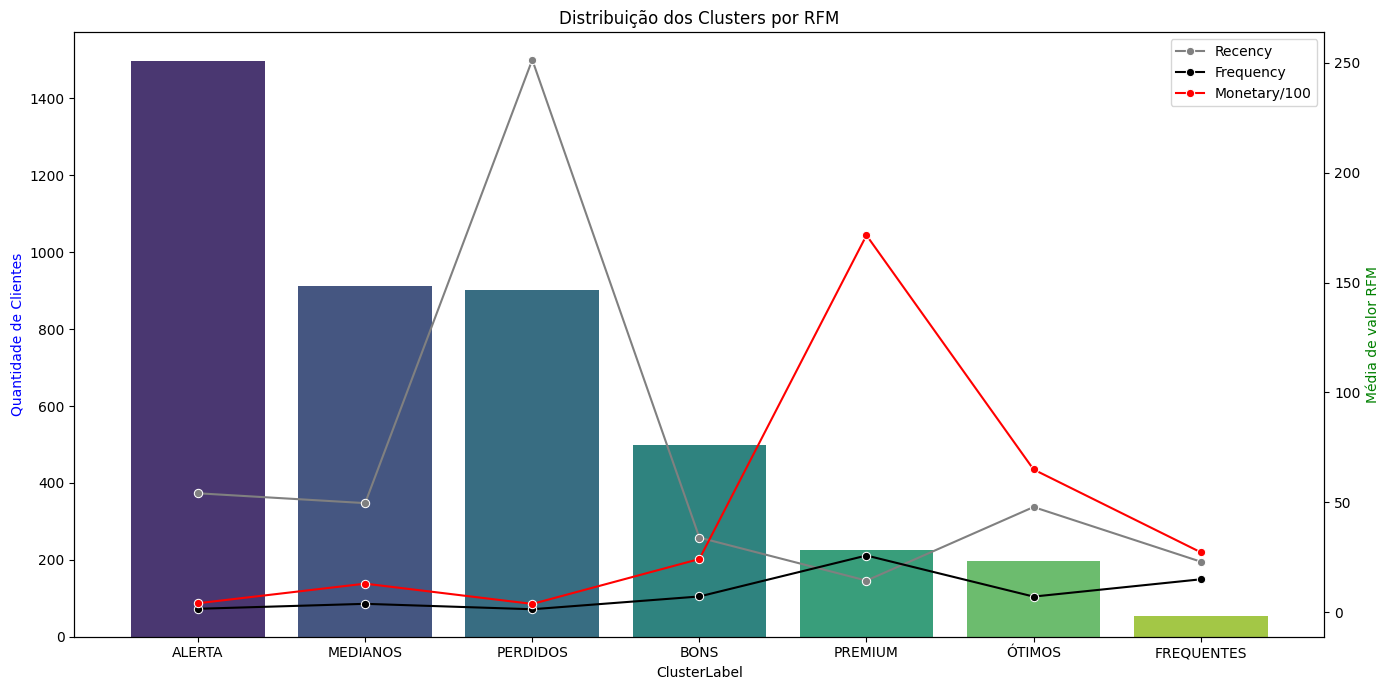

In [55]:
# Visualização Gráfica do projeto final
cluster_counts = df_full_clustering['ClusterLabel'].value_counts()
df_full_clustering["Monetary/100"] = df_full_clustering["Monetary"] / 100.00
feature_means = df_full_clustering.groupby('ClusterLabel')[['Recency', 'Frequency', 'Monetary/100']].mean()

fig, ax1 = plt.subplots(figsize=(14, 7))

sns.barplot(x=cluster_counts.index, y=cluster_counts.values, ax=ax1, palette='viridis', hue=cluster_counts.index)
ax1.set_ylabel('Quantidade de Clientes', color='b')
ax1.set_title('Distribuição dos Clusters por RFM')

ax2 = ax1.twinx()

sns.lineplot(data=feature_means, x='ClusterLabel', y='Recency', ax=ax2, label='Recency', color='gray', marker='o')
sns.lineplot(data=feature_means, x='ClusterLabel', y='Frequency', ax=ax2, label='Frequency', color='black', marker='o')
sns.lineplot(data=feature_means, x='ClusterLabel', y='Monetary/100', ax=ax2, label='Monetary/100', color='red', marker='o')
ax2.set_ylabel('Média de valor RFM', color='g')

plt.tight_layout()
plt.show()